/glade/derecho/scratch/renatob/tmp/ipykernel_123559/3296162937.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


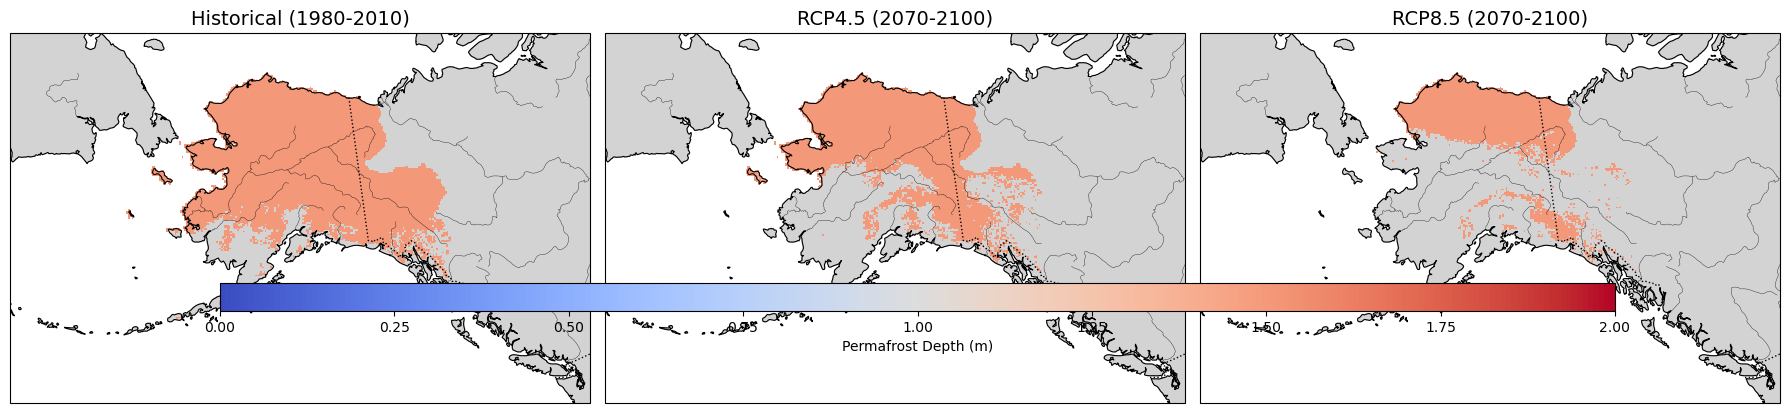

In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Paths to data files
data_dir = "/glade/derecho/scratch/renatob/vic_alaska/output/"
file_hist = data_dir + "cmip5_ensemble_eb_rcp45.nc"
file_rcp45 = data_dir + "cmip5_ensemble_eb_rcp45.nc"
file_rcp85 = data_dir + "cmip5_ensemble_eb_rcp85.nc"

# Define soil layer depths (m) corresponding to SOIL_TEMP1, SOIL_TEMP2, SOIL_TEMP3
depths = [0.15, 0.50, 1.50]  

# Projection settings (Same as reference script)
proj = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=64, standard_parallels=(55, 65))

# Function to compute permafrost depth
def compute_permafrost_depth(file_path, start_year, end_year):
    ds = xr.open_dataset(file_path)

    # Select time range
    ds = ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))

    # Extract mean temperature for each layer
    temp1 = ds["SOIL_TEMP1"].mean(dim="time")
    temp2 = ds["SOIL_TEMP2"].mean(dim="time")
    temp3 = ds["SOIL_TEMP3"].mean(dim="time")

    # Get spatial coordinates
    lon = ds["longitude"].isel(time=0)
    lat = ds["latitude"].isel(time=0)

    # Initialize permafrost depth as NaN
    permafrost_depth = xr.full_like(temp1, np.nan)

    # Assign permafrost depth based on the deepest frozen layer
    permafrost_depth = xr.where(temp1 < 0, depths[0], permafrost_depth)
    permafrost_depth = xr.where(temp2 < 0, depths[1], permafrost_depth)
    permafrost_depth = xr.where(temp3 < 0, depths[2], permafrost_depth)

    return permafrost_depth, lon, lat

# Compute permafrost depth for historical and future scenarios
pf_hist, lon, lat = compute_permafrost_depth(file_hist, 1980, 2010)
pf_rcp45, _, _ = compute_permafrost_depth(file_rcp45, 2070, 2100)
pf_rcp85, _, _ = compute_permafrost_depth(file_rcp85, 2070, 2100)

# Define figure layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": proj})
titles = ["Historical (1980-2010)", "RCP4.5 (2070-2100)", "RCP8.5 (2070-2100)"]
data = [pf_hist, pf_rcp45, pf_rcp85]

# Plot maps
for i, ax in enumerate(axes):
    ax.set_extent([-180, -120, 50, 72], crs=ccrs.PlateCarree())

    # Add base map features
    ax.add_feature(cfeature.LAND, color="lightgray")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.add_feature(cfeature.RIVERS, edgecolor="black", linewidth=0.25)

    # Contour plot
    im = ax.pcolormesh(
        lon, lat, data[i],
        transform=ccrs.PlateCarree(), cmap="coolwarm",
        shading="auto", vmin=0, vmax=2
    )

    ax.set_title(titles[i], fontsize=14)

# Add colorbar
cbar = fig.colorbar(im, ax=axes, orientation="horizontal", pad=0.1, aspect=50)
cbar.set_label("Permafrost Depth (m)")

# Adjust layout and save the figure
plt.tight_layout()
#plt.savefig("permafrost_depth_comparison.png", dpi=300)
plt.show()


In [7]:
print("Historical Permafrost Depth - Min:", pf_hist.min().values, "Max:", pf_hist.max().values)
print("RCP4.5 Permafrost Depth - Min:", pf_rcp45.min().values, "Max:", pf_rcp45.max().values)
print("RCP8.5 Permafrost Depth - Min:", pf_rcp85.min().values, "Max:", pf_rcp85.max().values)


Historical Permafrost Depth - Min: 0.5 Max: 1.5
RCP4.5 Permafrost Depth - Min: 1.5 Max: 1.5
RCP8.5 Permafrost Depth - Min: 1.5 Max: 1.5


/glade/derecho/scratch/renatob/tmp/ipykernel_123559/1200588679.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leaves space for the colorbar


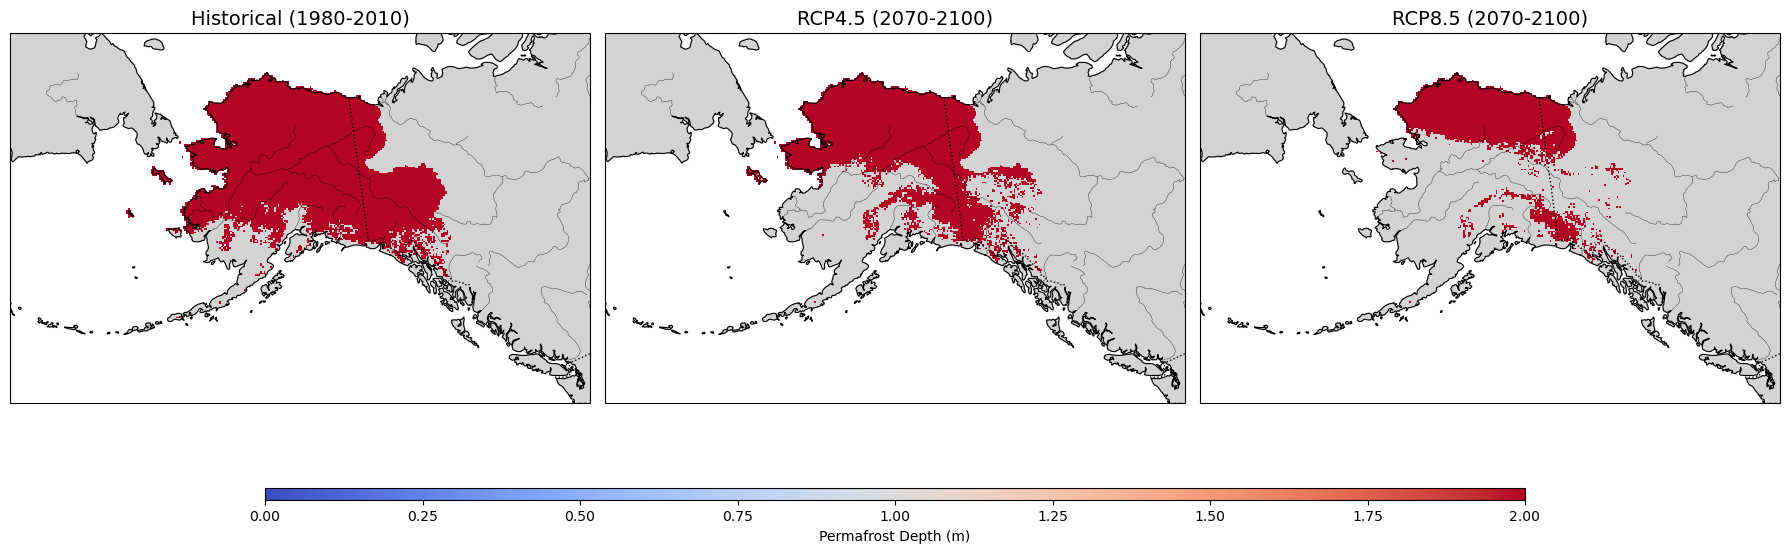

In [11]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Paths to data files
data_dir = "/glade/derecho/scratch/renatob/vic_alaska/output/"
file_hist = data_dir + "cmip5_ensemble_eb_rcp45.nc"
file_rcp45 = data_dir + "cmip5_ensemble_eb_rcp45.nc"
file_rcp85 = data_dir + "cmip5_ensemble_eb_rcp85.nc"

# **Corrected Soil Layer Depths (m)**
depths = [0.02042, 0.97047, 2.0]  

# Projection settings (Same as reference script)
proj = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=64, standard_parallels=(55, 65))

# Function to compute permafrost depth
def compute_permafrost_depth(file_path, start_year, end_year):
    ds = xr.open_dataset(file_path)

    # Ensure time is properly decoded
    ds["time"] = xr.decode_cf(ds).indexes["time"]

    # Select time range and compute mean over time
    ds_period = ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31")).mean(dim="time")

    # Extract soil temperatures
    temp1 = ds_period["SOIL_TEMP1"]
    temp2 = ds_period["SOIL_TEMP2"]
    temp3 = ds_period["SOIL_TEMP3"]

    # Get spatial coordinates
    lon = ds["longitude"] if "longitude" in ds.coords else ds["longitude"].isel(time=0)
    lat = ds["latitude"] if "latitude" in ds.coords else ds["latitude"].isel(time=0)

    # Initialize permafrost depth with NaN
    permafrost_depth = xr.full_like(temp1, np.nan)

    # Assign permafrost depth based on frozen layers
    permafrost_depth = xr.where(temp1 < 0, depths[0], permafrost_depth)
    permafrost_depth = xr.where(temp2 < 0, depths[1], permafrost_depth)
    permafrost_depth = xr.where(temp3 < 0, depths[2], permafrost_depth)

    return permafrost_depth, lon, lat

# Compute permafrost depth for historical and future scenarios
pf_hist, lon, lat = compute_permafrost_depth(file_hist, 1980, 2010)
pf_rcp45, _, _ = compute_permafrost_depth(file_rcp45, 2070, 2100)
pf_rcp85, _, _ = compute_permafrost_depth(file_rcp85, 2070, 2100)

# Define figure layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": proj})
titles = ["Historical (1980-2010)", "RCP4.5 (2070-2100)", "RCP8.5 (2070-2100)"]
data = [pf_hist, pf_rcp45, pf_rcp85]

# Plot maps
im = None  # Store last plotted image for colorbar reference
for i, ax in enumerate(axes):
    ax.set_extent([-180, -120, 50, 72], crs=ccrs.PlateCarree())

    # Add base map features
    ax.add_feature(cfeature.LAND, color="lightgray")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.add_feature(cfeature.RIVERS, edgecolor="black", linewidth=0.25)

    # Contour plot
    im = ax.pcolormesh(
        lon, lat, data[i],
        transform=ccrs.PlateCarree(), cmap="coolwarm",
        shading="auto", vmin=0, vmax=2
    )

    ax.set_title(titles[i], fontsize=14)

# Add colorbar **below the plots**
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Permafrost Depth (m)")

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leaves space for the colorbar
#plt.savefig("permafrost_depth_comparison.png", dpi=300)
plt.show()


In [12]:
print("Historical Permafrost Depth - Min:", np.nanmin(pf_hist.values), "Max:", np.nanmax(pf_hist.values))
print("RCP4.5 Permafrost Depth - Min:", np.nanmin(pf_rcp45.values), "Max:", np.nanmax(pf_rcp45.values))
print("RCP8.5 Permafrost Depth - Min:", np.nanmin(pf_rcp85.values), "Max:", np.nanmax(pf_rcp85.values))


Historical Permafrost Depth - Min: 0.97047 Max: 2.0
RCP4.5 Permafrost Depth - Min: 2.0 Max: 2.0
RCP8.5 Permafrost Depth - Min: 2.0 Max: 2.0


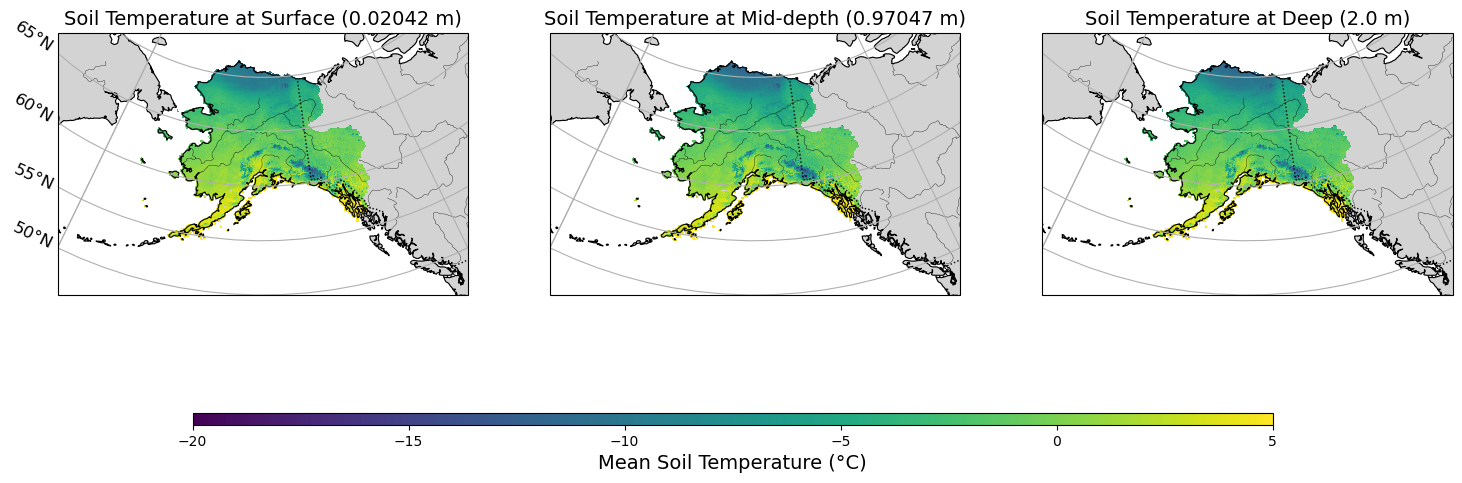

In [20]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

# Paths to data files
data_dir = "/glade/derecho/scratch/renatob/vic_alaska/output/"
file_hist = data_dir + "cmip5_ensemble_eb_rcp45.nc"

# Load dataset
ds = xr.open_dataset(file_hist)

# Select historical period (1980-2010) and compute mean temperature
ds_hist = ds.sel(time=slice("1980-01-01", "2010-12-31")).mean(dim="time")

# Extract soil temperatures for each depth
soil_temps = {
    "Surface (0.02042 m)": ds_hist["SOIL_TEMP1"],
    "Mid-depth (0.97047 m)": ds_hist["SOIL_TEMP2"],
    "Deep (2.0 m)": ds_hist["SOIL_TEMP3"],
}

# Extract spatial coordinates
lon = ds["longitude"].isel(time=0)
lat = ds["latitude"].isel(time=0)

# Projection settings
proj = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=64, standard_parallels=(55, 65))

# Define figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": proj})
cmap = "viridis"  # Using a sequential colormap as requested
vmin, vmax = -20, 5  # Adjust based on actual data

# Plot soil temperature for each depth
for i, (ax, (depth_label, temp)) in enumerate(zip(axes, soil_temps.items())):
    ax.set_extent([-180, -120, 50, 72], crs=ccrs.PlateCarree())

    # Add base map features
    ax.add_feature(cfeature.LAND, color="lightgray")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.add_feature(cfeature.RIVERS, edgecolor="black", linewidth=0.25)

    # Plot temperature map
    im = ax.pcolormesh(lon, lat, temp, transform=ccrs.PlateCarree(), cmap=cmap, shading="auto", vmin=vmin, vmax=vmax)

    # Add latitude labels on the leftmost plot only
    if i == 0:
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 12}
        gl.ylabel_style = {"size": 12}
    else:
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.left_labels = False
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 12}

    ax.set_title(f"Soil Temperature at {depth_label}", fontsize=14)

# Add colorbar **below** the plots
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02])  # Adjust position of colorbar
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Mean Soil Temperature (°C)", fontsize=14)

# Adjust layout and save figure
plt.subplots_adjust(bottom=0.15)  # Ensures the colorbar doesn't overlap
# plt.savefig("soil_temperature_historical_fixed.png", dpi=300)
plt.show()


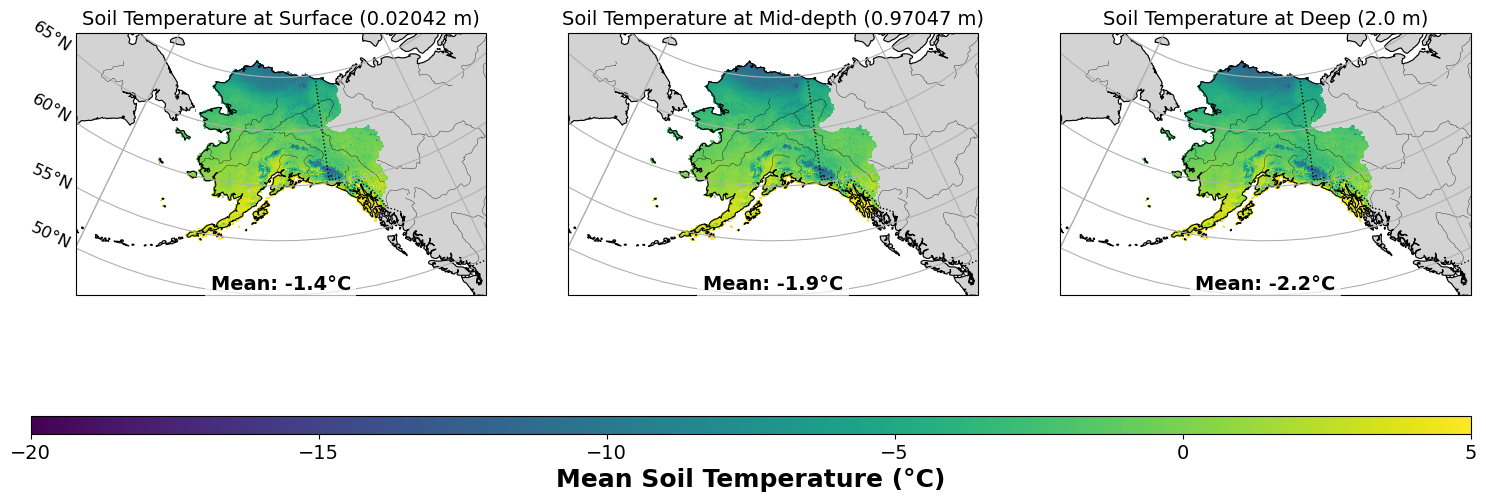

In [22]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Paths to data files
data_dir = "/glade/derecho/scratch/renatob/vic_alaska/output/"
file_hist = data_dir + "cmip5_ensemble_eb_rcp45.nc"

# Load dataset
ds = xr.open_dataset(file_hist)

# Select historical period (1980-2010) and compute mean temperature
ds_hist = ds.sel(time=slice("1980-01-01", "2010-12-31")).mean(dim="time")

# Extract soil temperatures for each depth
soil_temps = {
    "Surface (0.02042 m)": ds_hist["SOIL_TEMP1"],
    "Mid-depth (0.97047 m)": ds_hist["SOIL_TEMP2"],
    "Deep (2.0 m)": ds_hist["SOIL_TEMP3"],
}

# Extract spatial coordinates
lon = ds["longitude"].isel(time=0)
lat = ds["latitude"].isel(time=0)

# Compute mean temperatures for annotation
mean_temps = {label: np.nanmean(temp.values) for label, temp in soil_temps.items()}

# Projection settings
proj = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=64, standard_parallels=(55, 65))

# Define figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": proj})
cmap = "viridis"  # Using a sequential colormap as requested
vmin, vmax = -20, 5  # Adjust based on actual data

# Plot soil temperature for each depth
for i, (ax, (depth_label, temp)) in enumerate(zip(axes, soil_temps.items())):
    ax.set_extent([-180, -120, 50, 72], crs=ccrs.PlateCarree())

    # Add base map features
    ax.add_feature(cfeature.LAND, color="lightgray")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.add_feature(cfeature.RIVERS, edgecolor="black", linewidth=0.25)

    # Plot temperature map
    im = ax.pcolormesh(lon, lat, temp, transform=ccrs.PlateCarree(), cmap=cmap, shading="auto", vmin=vmin, vmax=vmax)

    # Add latitude labels on the leftmost plot only
    if i == 0:
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 12}
        gl.ylabel_style = {"size": 12}
    else:
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.left_labels = False
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 12}

    # Set title
    ax.set_title(f"Soil Temperature at {depth_label}", fontsize=14)

    # Add mean temperature INSIDE each subplot (bottom)
    ax.text(0.5, 0.02, f"Mean: {mean_temps[depth_label]:.1f}°C", transform=ax.transAxes,
            ha="center", fontsize=14, fontweight="bold", bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Add colorbar **starting and ending at the first and last subplot**
cbar_ax = fig.add_axes([0.1, 0.08, 0.8, 0.03])  # Adjusted start and end points
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Mean Soil Temperature (°C)", fontsize=18, fontweight="bold")  # Bigger label
cbar.ax.tick_params(labelsize=14)  # Bigger tick labels below colorbar

# Adjust layout and save figure
plt.subplots_adjust(bottom=0.18)  # Ensures proper spacing
# plt.savefig("soil_temperature_historical_final.png", dpi=300)
plt.show()


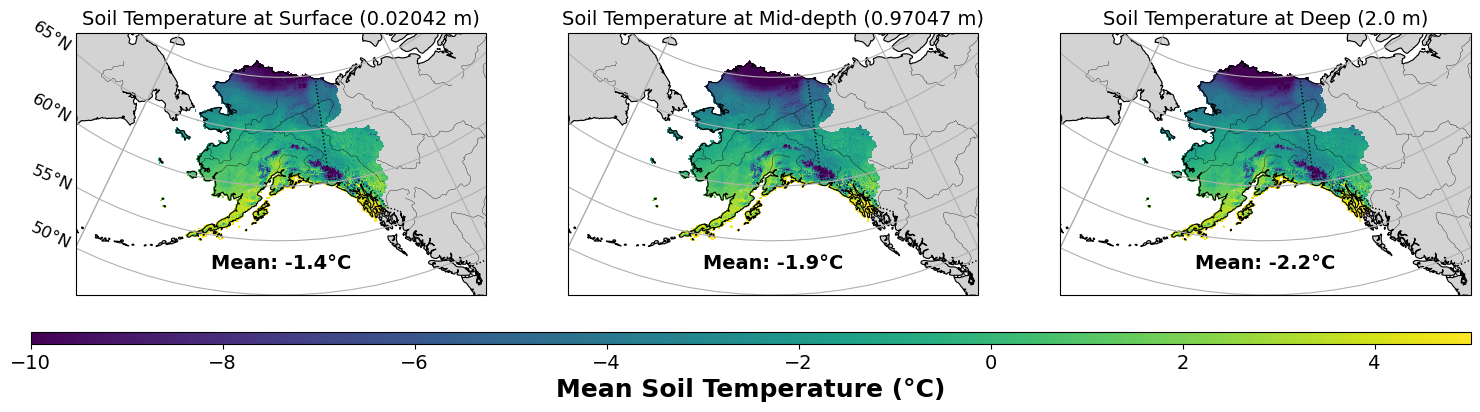

In [42]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Paths to data files
data_dir = "/glade/derecho/scratch/renatob/vic_alaska/output/"
file_hist = data_dir + "cmip5_ensemble_eb_rcp45.nc"

# Load dataset
ds = xr.open_dataset(file_hist)

# Select historical period (1980-2010) and compute mean temperature
ds_hist = ds.sel(time=slice("1980-01-01", "2010-12-31")).mean(dim="time")

# Extract soil temperatures for each depth
soil_temps = {
    "Surface (0.02042 m)": ds_hist["SOIL_TEMP1"],
    "Mid-depth (0.97047 m)": ds_hist["SOIL_TEMP2"],
    "Deep (2.0 m)": ds_hist["SOIL_TEMP3"],
}

# Extract spatial coordinates
lon = ds["longitude"].isel(time=0)
lat = ds["latitude"].isel(time=0)

# Compute mean temperatures for annotation
mean_temps = {label: np.nanmean(temp.values) for label, temp in soil_temps.items()}

# Projection settings
proj = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=64, standard_parallels=(55, 65))

# Define figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": proj})
cmap = "viridis"  # Using a sequential colormap as requested
vmin, vmax = -10, 5  # Adjust based on actual data

# Plot soil temperature for each depth
for i, (ax, (depth_label, temp)) in enumerate(zip(axes, soil_temps.items())):
    ax.set_extent([-180, -120, 50, 72], crs=ccrs.PlateCarree())

    # Add base map features
    ax.add_feature(cfeature.LAND, color="lightgray")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.add_feature(cfeature.RIVERS, edgecolor="black", linewidth=0.25)

    # Plot temperature map
    im = ax.pcolormesh(lon, lat, temp, transform=ccrs.PlateCarree(), cmap=cmap, shading="auto", vmin=vmin, vmax=vmax)

    # Add latitude labels on the leftmost plot only
    if i == 0:
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 12}
        gl.ylabel_style = {"size": 12}
    else:
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.left_labels = False
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 12}

    # Set title
    ax.set_title(f"Soil Temperature at {depth_label}", fontsize=14)

    # Add mean temperature INSIDE each subplot (slightly higher for better visibility)
    ax.text(0.5, 0.1, f"Mean: {mean_temps[depth_label]:.1f}°C", transform=ax.transAxes,
            ha="center", fontsize=14, fontweight="bold", bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# **NEW POSITION FOR COLORBAR** - Closer to the plots!
cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.02])  # **Moved up significantly**
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Mean Soil Temperature (°C)", fontsize=18, fontweight="bold")  # Bigger label
cbar.ax.tick_params(labelsize=14)  # Bigger tick labels below colorbar

# Adjust layout and save figure
plt.subplots_adjust(bottom=0.12)  # **No excessive white space!**
# plt.savefig("soil_temperature_historical_final.png", dpi=300)
plt.show()


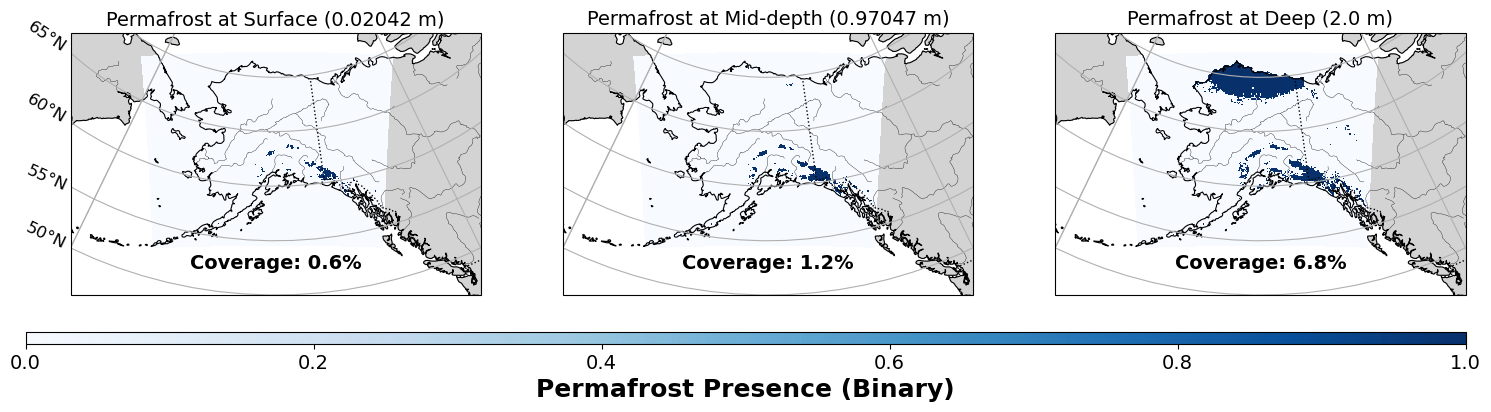

In [43]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Paths to data files
data_dir = "/glade/derecho/scratch/renatob/vic_alaska/output/"
file_hist = data_dir + "cmip5_ensemble_eb_rcp45.nc"

# Load dataset
ds = xr.open_dataset(file_hist)

# Select historical period (1980-2010)
ds_hist = ds.sel(time=slice("1980-01-01", "2010-12-31"))

# Extract soil temperatures for each depth
soil_temps = {
    "Surface (0.02042 m)": ds_hist["SOIL_TEMP1"],
    "Mid-depth (0.97047 m)": ds_hist["SOIL_TEMP2"],
    "Deep (2.0 m)": ds_hist["SOIL_TEMP3"],
}

# Extract spatial coordinates
lon = ds["longitude"].isel(time=0)
lat = ds["latitude"].isel(time=0)

# Compute permafrost (areas where temperature ≤ 0°C for at least two consecutive years)
permafrost_areas = {label: (temp <= 0).mean(dim="time") >= 1 for label, temp in soil_temps.items()}

# Compute permafrost coverage percentage
mean_permafrost = {label: np.nanmean(permafrost.values) * 100 for label, permafrost in permafrost_areas.items()}

# Projection settings
proj = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=64, standard_parallels=(55, 65))

# Define figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": proj})
cmap = "Blues"  # Permafrost = Blue, No permafrost = White

# Plot permafrost areas for each depth
for i, (ax, (depth_label, permafrost)) in enumerate(zip(axes, permafrost_areas.items())):
    ax.set_extent([-180, -120, 50, 72], crs=ccrs.PlateCarree())

    # Add base map features
    ax.add_feature(cfeature.LAND, color="lightgray")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.add_feature(cfeature.RIVERS, edgecolor="black", linewidth=0.25)

    # Plot permafrost map (1 = Permafrost, 0 = No Permafrost)
    im = ax.pcolormesh(lon, lat, permafrost, transform=ccrs.PlateCarree(), cmap=cmap, shading="auto")

    # Add latitude labels on the leftmost plot only
    if i == 0:
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 12}
        gl.ylabel_style = {"size": 12}
    else:
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.left_labels = False
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 12}

    # Set title
    ax.set_title(f"Permafrost at {depth_label}", fontsize=14)

    # Add mean permafrost percentage INSIDE each subplot (slightly higher for visibility)
    ax.text(0.5, 0.1, f"Coverage: {mean_permafrost[depth_label]:.1f}%", transform=ax.transAxes,
            ha="center", fontsize=14, fontweight="bold", bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# **NEW POSITION FOR COLORBAR** - Closer to the plots!
cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.02])  # **Spans full width**
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Permafrost Presence (Binary)", fontsize=18, fontweight="bold")  # Bigger label
cbar.ax.tick_params(labelsize=14)  # Bigger tick labels below colorbar

# Adjust layout and save figure
plt.subplots_adjust(bottom=0.12)  # **No excessive white space!**
# plt.savefig("permafrost_historical.png", dpi=300)
plt.show()


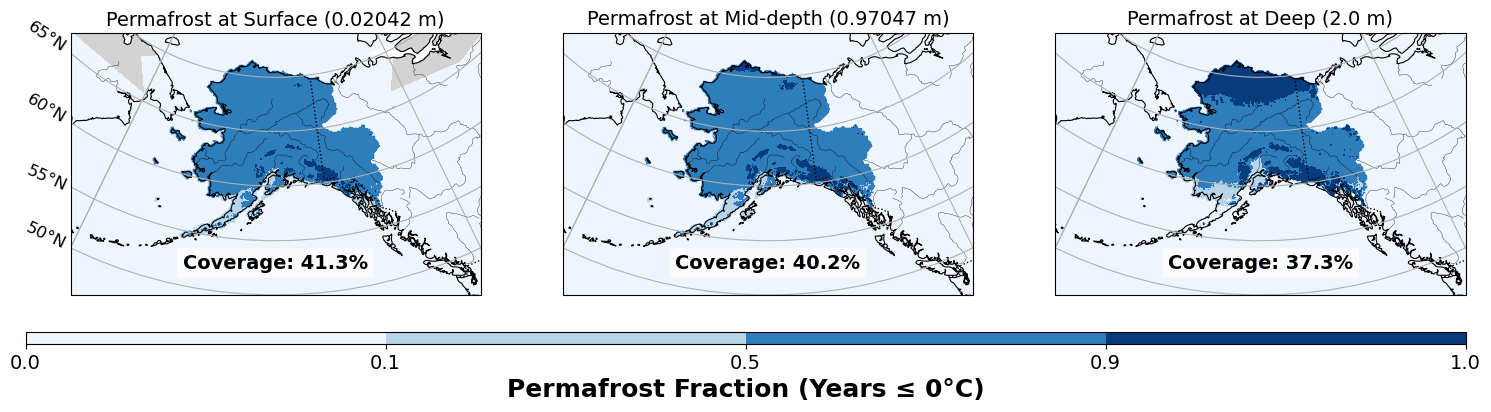

In [44]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Paths to data files
data_dir = "/glade/derecho/scratch/renatob/vic_alaska/output/"
file_hist = data_dir + "cmip5_ensemble_eb_rcp45.nc"

# Load dataset
ds = xr.open_dataset(file_hist)

# Select historical period (1980-2010)
ds_hist = ds.sel(time=slice("1980-01-01", "2010-12-31"))

# Extract soil temperatures for each depth
soil_temps = {
    "Surface (0.02042 m)": ds_hist["SOIL_TEMP1"],
    "Mid-depth (0.97047 m)": ds_hist["SOIL_TEMP2"],
    "Deep (2.0 m)": ds_hist["SOIL_TEMP3"],
}

# Extract spatial coordinates
lon = ds["longitude"].isel(time=0)
lat = ds["latitude"].isel(time=0)

# Compute permafrost frequency (fraction of years where temp <= 0°C)
permafrost_fraction = {label: (temp <= 0).mean(dim="time") for label, temp in soil_temps.items()}

# Projection settings
proj = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=64, standard_parallels=(55, 65))

# Define figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": proj})
cmap = "Blues"  # Using a gradient colormap
levels = [0, 0.1, 0.5, 0.9, 1]  # Permafrost categories

# Plot permafrost for each depth
for i, (ax, (depth_label, permafrost)) in enumerate(zip(axes, permafrost_fraction.items())):
    ax.set_extent([-180, -120, 50, 72], crs=ccrs.PlateCarree())

    # Add base map features
    ax.add_feature(cfeature.LAND, color="lightgray")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.add_feature(cfeature.RIVERS, edgecolor="black", linewidth=0.25)

    # Plot permafrost fraction
    im = ax.contourf(lon, lat, permafrost, levels=levels, cmap=cmap, transform=ccrs.PlateCarree())

    # Add latitude labels on the leftmost plot only
    if i == 0:
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 12}
        gl.ylabel_style = {"size": 12}
    else:
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.left_labels = False
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 12}

    # Compute coverage percentage
    coverage = (permafrost > 0).mean().values * 100

    # Set title
    ax.set_title(f"Permafrost at {depth_label}", fontsize=14)

    # Add coverage annotation inside each subplot
    ax.text(0.5, 0.1, f"Coverage: {coverage:.1f}%", transform=ax.transAxes,
            ha="center", fontsize=14, fontweight="bold", bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# **NEW POSITION FOR COLORBAR** - Closer to the plots!
cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Permafrost Fraction (Years ≤ 0°C)", fontsize=18, fontweight="bold")
cbar.ax.tick_params(labelsize=14)

# Adjust layout and save figure
plt.subplots_adjust(bottom=0.12)
plt.show()


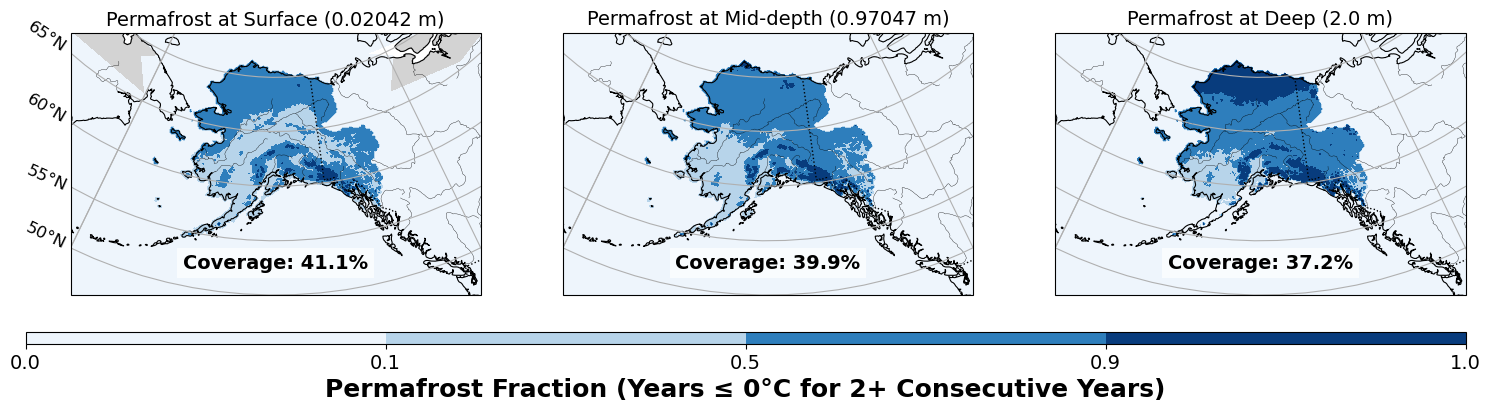

In [46]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Paths to data files
data_dir = "/glade/derecho/scratch/renatob/vic_alaska/output/"
file_hist = data_dir + "cmip5_ensemble_eb_rcp45.nc"

# Load dataset
ds = xr.open_dataset(file_hist)

# Select historical period (1980-2010)
ds_hist = ds.sel(time=slice("1980-01-01", "2010-12-31"))

# Extract soil temperatures for each depth
soil_temps = {
    "Surface (0.02042 m)": ds_hist["SOIL_TEMP1"],
    "Mid-depth (0.97047 m)": ds_hist["SOIL_TEMP2"],
    "Deep (2.0 m)": ds_hist["SOIL_TEMP3"],
}

# Extract spatial coordinates
lon = ds["longitude"].isel(time=0)
lat = ds["latitude"].isel(time=0)

# Function to compute **consecutive years below 0°C**
def permafrost_consecutive_years(temp, min_years=2):
    """
    Compute permafrost fraction by checking locations where temperature is ≤ 0°C
    for at least `min_years` consecutive years.
    """
    frozen_years = temp <= 0  # Boolean mask where temperature ≤ 0°C
    rolling_sum = frozen_years.rolling(time=min_years, center=False).sum()
    consecutive_frozen = rolling_sum >= min_years
    return consecutive_frozen.mean(dim="time")

# Compute permafrost fraction with at least **2 consecutive years below 0°C**
permafrost_fraction = {label: permafrost_consecutive_years(temp, min_years=2) for label, temp in soil_temps.items()}

# Projection settings
proj = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=64, standard_parallels=(55, 65))

# Define figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": proj})
cmap = "Blues"
levels = [0, 0.1, 0.5, 0.9, 1]  # Permafrost categories

# Plot permafrost for each depth
for i, (ax, (depth_label, permafrost)) in enumerate(zip(axes, permafrost_fraction.items())):
    ax.set_extent([-180, -120, 50, 72], crs=ccrs.PlateCarree())

    # Add base map features
    ax.add_feature(cfeature.LAND, color="lightgray")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.add_feature(cfeature.RIVERS, edgecolor="black", linewidth=0.25)

    # Plot permafrost fraction
    im = ax.contourf(lon, lat, permafrost, levels=levels, cmap=cmap, transform=ccrs.PlateCarree())

    # Add latitude labels on the leftmost plot only
    if i == 0:
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 12}
        gl.ylabel_style = {"size": 12}
    else:
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.left_labels = False
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 12}

    # Compute coverage percentage
    coverage = (permafrost > 0).mean().values * 100

    # Set title
    ax.set_title(f"Permafrost at {depth_label}", fontsize=14)

    # Add coverage annotation inside each subplot
    ax.text(0.5, 0.1, f"Coverage: {coverage:.1f}%", transform=ax.transAxes,
            ha="center", fontsize=14, fontweight="bold", bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# **NEW POSITION FOR COLORBAR** - Closer to the plots!
cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Permafrost Fraction (Years ≤ 0°C for 2+ Consecutive Years)", fontsize=18, fontweight="bold")
cbar.ax.tick_params(labelsize=14)

# Adjust layout and save figure
plt.subplots_adjust(bottom=0.12)
plt.show()


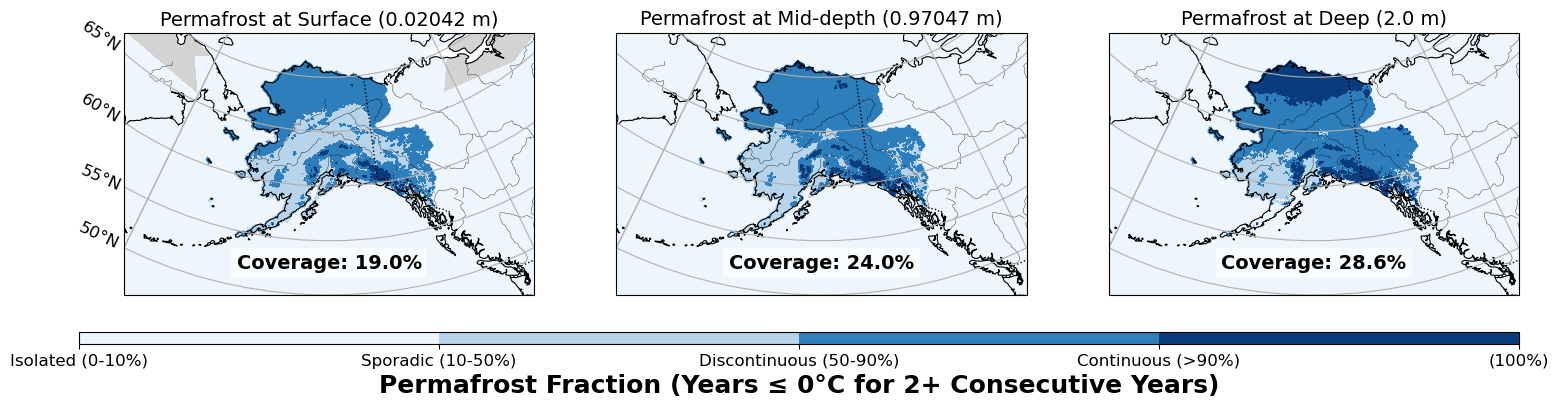

In [51]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Paths to data files
data_dir = "/glade/derecho/scratch/renatob/vic_alaska/output/"
file_hist = data_dir + "cmip5_ensemble_eb_rcp45.nc"

# Load dataset
ds = xr.open_dataset(file_hist)

# Select historical period (1980-2010)
ds_hist = ds.sel(time=slice("1980-01-01", "2010-12-31"))

# Extract soil temperatures for each depth
soil_temps = {
    "Surface (0.02042 m)": ds_hist["SOIL_TEMP1"],
    "Mid-depth (0.97047 m)": ds_hist["SOIL_TEMP2"],
    "Deep (2.0 m)": ds_hist["SOIL_TEMP3"],
}

# Extract spatial coordinates
lon = ds["longitude"].isel(time=0)
lat = ds["latitude"].isel(time=0)

# Function to compute **consecutive years below 0°C**
def permafrost_consecutive_years(temp, min_years=2):
    """
    Compute permafrost fraction by checking locations where temperature is ≤ 0°C
    for at least `min_years` consecutive years.
    """
    frozen_years = temp <= 0  # Boolean mask where temperature ≤ 0°C
    rolling_sum = frozen_years.rolling(time=min_years, center=False).sum()
    consecutive_frozen = rolling_sum >= min_years
    return consecutive_frozen.mean(dim="time")

# Compute permafrost fraction with at least **2 consecutive years below 0°C**
permafrost_fraction = {label: permafrost_consecutive_years(temp, min_years=2) for label, temp in soil_temps.items()}

# Projection settings
proj = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=64, standard_parallels=(55, 65))

# Define figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": proj})
cmap = "Blues"
levels = [0, 0.1, 0.5, 0.9, 1]  # Permafrost categories

# Define category labels
#category_labels = ["Absent (0%)", "Isolated (0-10%)", "Sporadic (10-50%)", "Discontinuous (50-90%)", "Continuous (>90%)"]
category_labels = ["Isolated (0-10%)", "Sporadic (10-50%)", "Discontinuous (50-90%)", "Continuous (>90%)", "(100%)"]

# Plot permafrost for each depth
for i, (ax, (depth_label, permafrost)) in enumerate(zip(axes, permafrost_fraction.items())):
    ax.set_extent([-180, -120, 50, 72], crs=ccrs.PlateCarree())

    # Add base map features
    ax.add_feature(cfeature.LAND, color="lightgray")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
    ax.add_feature(cfeature.RIVERS, edgecolor="black", linewidth=0.25)

    # Plot permafrost fraction
    im = ax.contourf(lon, lat, permafrost, levels=levels, cmap=cmap, transform=ccrs.PlateCarree())

    # Add latitude labels on the leftmost plot only
    if i == 0:
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 12}
        gl.ylabel_style = {"size": 12}
    else:
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.left_labels = False
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 12}

    # Compute **only Continuous & Discontinuous Permafrost Coverage**
    coverage = ((permafrost > 0.5).mean().values) * 100

    # Set title
    ax.set_title(f"Permafrost at {depth_label}", fontsize=14)

    # Add coverage annotation inside each subplot
    ax.text(0.5, 0.1, f"Coverage: {coverage:.1f}%", transform=ax.transAxes,
            ha="center", fontsize=14, fontweight="bold", bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# **NEW POSITION FOR COLORBAR** - Closer to the plots!
cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Permafrost Fraction (Years ≤ 0°C for 2+ Consecutive Years)", fontsize=18, fontweight="bold")
cbar.ax.tick_params(labelsize=14)

# **Add category labels above colorbar**
cbar.ax.set_xticks([0, 0.1, 0.5, 0.9, 1])
cbar.ax.set_xticklabels(category_labels, fontsize=12, rotation=0, ha="center")

# Adjust layout and save figure
plt.subplots_adjust(bottom=0.12)
plt.show()


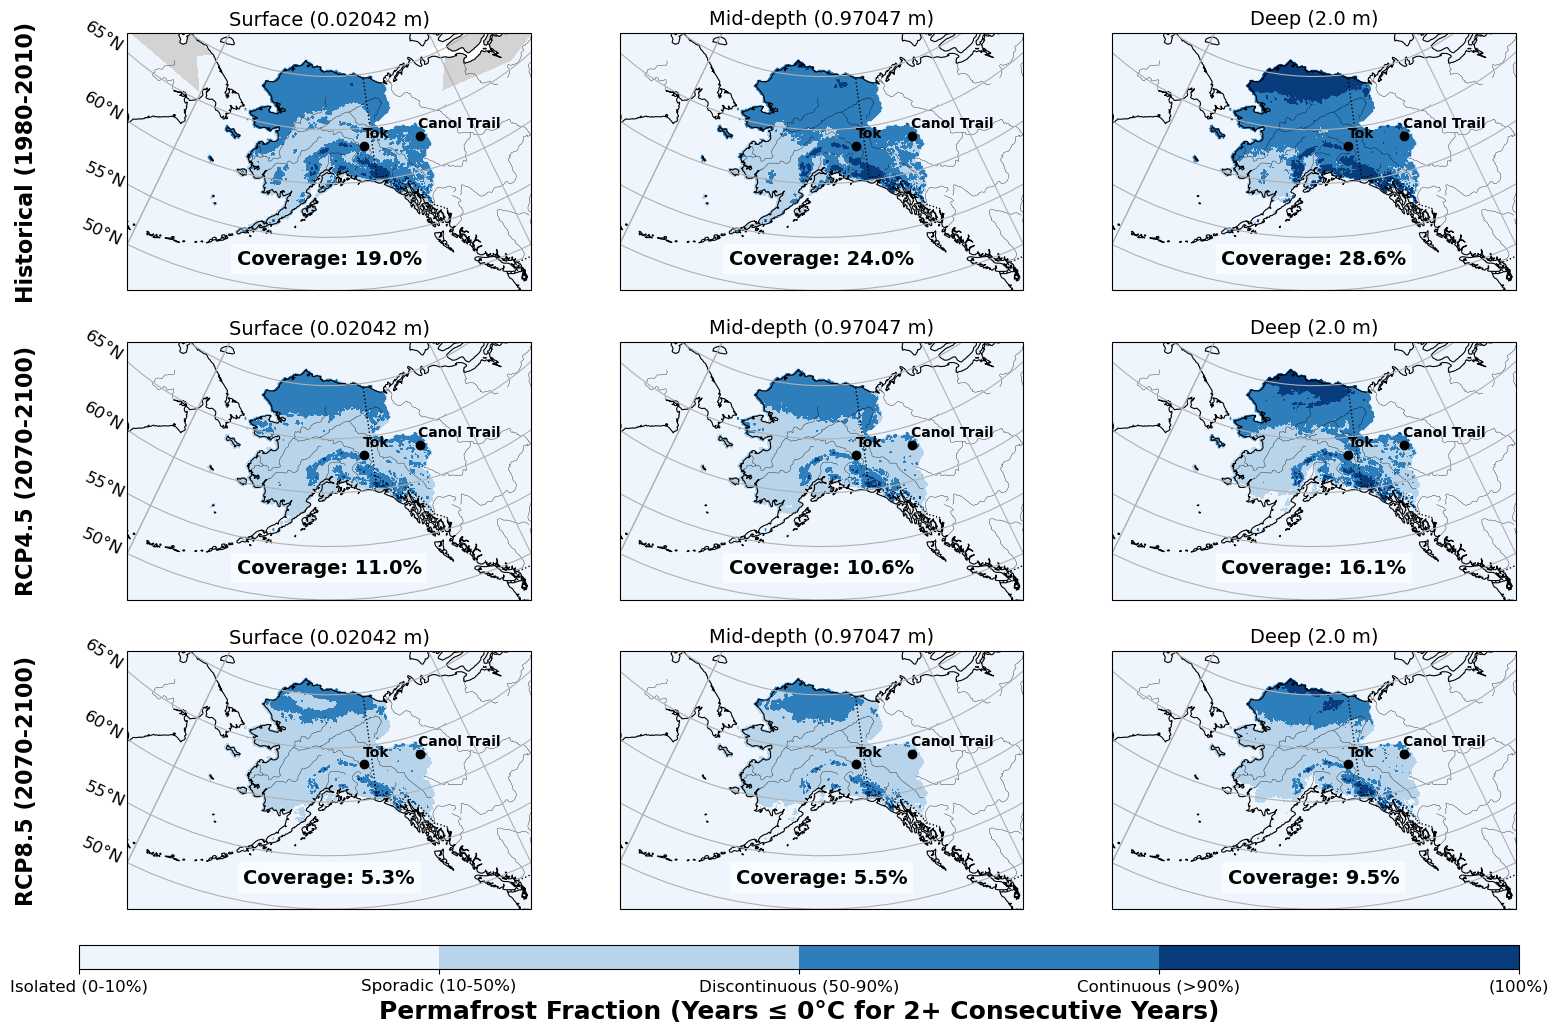

In [54]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Paths to data files
data_dir = "/glade/derecho/scratch/renatob/vic_alaska/output/"
file_hist = data_dir + "cmip5_ensemble_eb_rcp45.nc"
file_rcp45 = data_dir + "cmip5_ensemble_eb_rcp45.nc"
file_rcp85 = data_dir + "cmip5_ensemble_eb_rcp85.nc"

# Load datasets
ds_hist = xr.open_dataset(file_hist).sel(time=slice("1980-01-01", "2010-12-31"))
ds_rcp45 = xr.open_dataset(file_rcp45).sel(time=slice("2070-01-01", "2100-12-31"))
ds_rcp85 = xr.open_dataset(file_rcp85).sel(time=slice("2070-01-01", "2100-12-31"))

# Extract soil temperatures for each depth
depths = {
    "Surface (0.02042 m)": "SOIL_TEMP1",
    "Mid-depth (0.97047 m)": "SOIL_TEMP2",
    "Deep (2.0 m)": "SOIL_TEMP3",
}

# Extract spatial coordinates
lon = ds_hist["longitude"].isel(time=0)
lat = ds_hist["latitude"].isel(time=0)

# Function to compute permafrost fraction (2+ consecutive years below 0°C)
def permafrost_consecutive_years(ds, temp_var, min_years=2):
    temp = ds[temp_var]
    frozen_years = temp <= 0
    rolling_sum = frozen_years.rolling(time=min_years, center=False).sum()
    consecutive_frozen = rolling_sum >= min_years
    return consecutive_frozen.mean(dim="time")

# Compute permafrost fraction for historical, RCP4.5, and RCP8.5
permafrost_data = {
    "Historical": {label: permafrost_consecutive_years(ds_hist, var) for label, var in depths.items()},
    "RCP4.5": {label: permafrost_consecutive_years(ds_rcp45, var) for label, var in depths.items()},
    "RCP8.5": {label: permafrost_consecutive_years(ds_rcp85, var) for label, var in depths.items()},
}

# Projection settings
proj = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=64, standard_parallels=(55, 65))

# Define figure and subplots (3 depths x 3 scenarios)
fig, axes = plt.subplots(3, 3, figsize=(18, 12), subplot_kw={"projection": proj})
cmap = "Blues"
levels = [0, 0.1, 0.5, 0.9, 1]  # Permafrost categories

# Permafrost category labels
category_labels = ["Isolated (0-10%)", "Sporadic (10-50%)", "Discontinuous (50-90%)", "Continuous (>90%)", "(100%)"]

# Station locations
stations = [
    {"name": "Tok", "lon": -142.8089, "lat": 63.3286},
    {"name": "Canol Trail", "lon": -130.98, "lat": 63.25},
]

# Period labels for left side
period_labels = ["Historical (1980-2010)", "RCP4.5 (2070-2100)", "RCP8.5 (2070-2100)"]

# Plot permafrost for each scenario and depth
for row_idx, (scenario, permafrost_layers) in enumerate(permafrost_data.items()):
    for col_idx, (depth_label, permafrost) in enumerate(permafrost_layers.items()):
        ax = axes[row_idx, col_idx]
        ax.set_extent([-180, -120, 50, 72], crs=ccrs.PlateCarree())

        # Add base map features
        ax.add_feature(cfeature.LAND, color="lightgray")
        ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
        ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=1)
        ax.add_feature(cfeature.RIVERS, edgecolor="black", linewidth=0.25)

        # Plot permafrost fraction
        im = ax.contourf(lon, lat, permafrost, levels=levels, cmap=cmap, transform=ccrs.PlateCarree())

        # Add latitude labels on the leftmost plots
        if col_idx == 0:
            gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
            gl.top_labels = False
            gl.right_labels = False
            gl.xlabel_style = {"size": 12}
            gl.ylabel_style = {"size": 12}
        else:
            gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
            gl.left_labels = False
            gl.top_labels = False
            gl.right_labels = False
            gl.xlabel_style = {"size": 12}

        # Compute **only Continuous & Discontinuous Permafrost Coverage**
        coverage = ((permafrost > 0.5).mean().values) * 100

        # Set title
        ax.set_title(f"{depth_label}", fontsize=14)

        # Add station locations
        for station in stations:
            ax.plot(station["lon"], station["lat"], marker="o", color="black", markersize=6, transform=ccrs.PlateCarree())
            ax.text(station["lon"], station["lat"] + 0.5, station["name"], transform=ccrs.PlateCarree(),
                    fontsize=10, ha="left", va="bottom", fontweight="bold")

        # Add coverage annotation inside each subplot
        ax.text(0.5, 0.1, f"Coverage: {coverage:.1f}%", transform=ax.transAxes,
                ha="center", fontsize=14, fontweight="bold", bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Add vertical period labels only on the left-hand side
    axes[row_idx, 0].text(-0.25, 0.5, period_labels[row_idx], transform=axes[row_idx, 0].transAxes,
                          fontsize=16, fontweight="bold", rotation=90, va="center", ha="center")

# **NEW POSITION FOR COLORBAR** - Closer to the plots!
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Permafrost Fraction (Years ≤ 0°C for 2+ Consecutive Years)", fontsize=18, fontweight="bold")
cbar.ax.tick_params(labelsize=14)

# **Add category labels above colorbar**
cbar.ax.set_xticks([0, 0.1, 0.5, 0.9, 1])
cbar.ax.set_xticklabels(category_labels, fontsize=12, rotation=0, ha="center")

# Adjust layout and save figure
plt.subplots_adjust(bottom=0.15)
plt.savefig("Fig3.pdf", dpi=300, bbox_inches="tight")
plt.show()


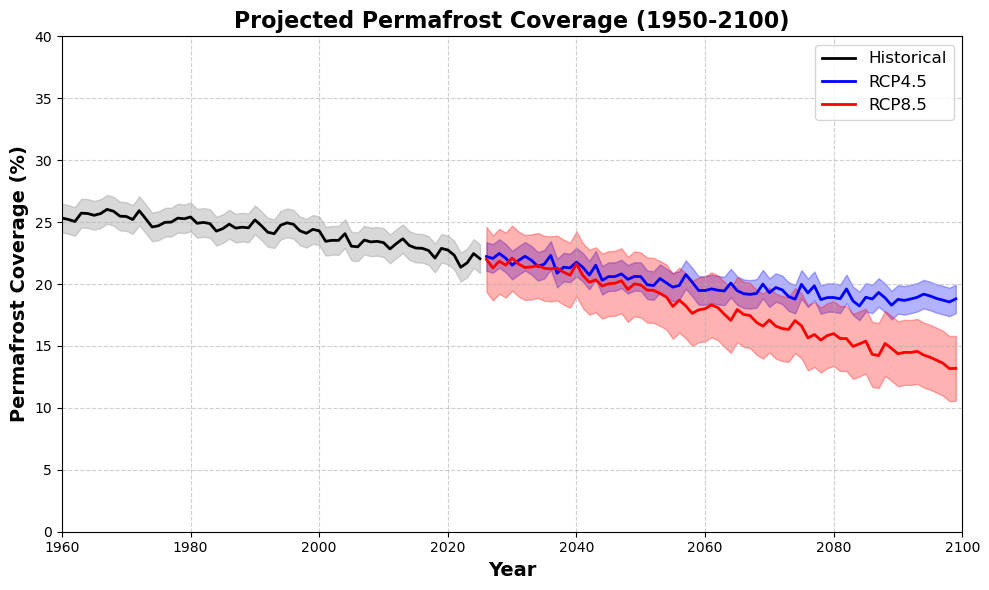

In [82]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Paths to data files
data_dir = "/glade/derecho/scratch/renatob/vic_alaska/output/"
file_hist = data_dir + "cmip5_ensemble_eb_rcp45.nc"
file_rcp45 = data_dir + "cmip5_ensemble_eb_rcp45.nc"
file_rcp85 = data_dir + "cmip5_ensemble_eb_rcp85.nc"

# Load datasets
ds_hist = xr.open_dataset(file_hist).sel(time=slice("1950-01-01", "2025-12-31"))
ds_rcp45 = xr.open_dataset(file_rcp45).sel(time=slice("2025-01-01", "2100-12-31"))
ds_rcp85 = xr.open_dataset(file_rcp85).sel(time=slice("2025-01-01", "2100-12-31"))

# Function to compute permafrost coverage over time (removing seasonality)
def permafrost_coverage(ds, temp_var, min_years=2):
    temp = ds[temp_var]
    frozen_years = temp <= 0  # Boolean mask where temp ≤ 0°C
    rolling_sum = frozen_years.rolling(time=min_years, center=False).sum()
    consecutive_frozen = rolling_sum >= min_years
    coverage = consecutive_frozen.mean(dim=["x", "y"]) * 100  # Convert to percentage
    
    # **Convert from monthly to yearly averages**
    coverage_yearly = coverage.groupby("time.year").mean()
    
    return coverage_yearly.compute()

# Compute permafrost coverage for historical and future scenarios
coverage_hist = permafrost_coverage(ds_hist, "SOIL_TEMP3")  # Deep layer
coverage_rcp45 = permafrost_coverage(ds_rcp45, "SOIL_TEMP3")
coverage_rcp85 = permafrost_coverage(ds_rcp85, "SOIL_TEMP3")

# Convert permafrost coverage to NumPy arrays
years_hist = coverage_hist.year.values
years_rcp = coverage_rcp45.year.values  # Both RCP datasets share the same years
coverage_hist = coverage_hist.values
coverage_rcp45 = coverage_rcp45.values
coverage_rcp85 = coverage_rcp85.values

# Compute uncertainty as ±1 standard deviation over time
uncertainty_hist = np.std(coverage_hist)
uncertainty_rcp45 = np.std(coverage_rcp45)
uncertainty_rcp85 = np.std(coverage_rcp85)

# Plot setup
fig, ax = plt.subplots(figsize=(10, 6))

# Historical coverage (1950-2025)
ax.plot(years_hist, coverage_hist, color="black", linewidth=2, label="Historical")
ax.fill_between(years_hist, 
                coverage_hist - uncertainty_hist, 
                coverage_hist + uncertainty_hist, 
                color="gray", alpha=0.3)

# RCP4.5 (2025-2100)
ax.plot(years_rcp[1:], coverage_rcp45[1:], color="blue", linewidth=2, label="RCP4.5")
ax.fill_between(years_rcp[1:], 
                coverage_rcp45[1:] - uncertainty_rcp45, 
                coverage_rcp45[1:] + uncertainty_rcp45, 
                color="blue", alpha=0.3)

# RCP8.5 (2025-2100)
ax.plot(years_rcp[1:], coverage_rcp85[1:], color="red", linewidth=2, label="RCP8.5")
ax.fill_between(years_rcp[1:], 
                coverage_rcp85[1:] - uncertainty_rcp85, 
                coverage_rcp85[1:] + uncertainty_rcp85, 
                color="red", alpha=0.3)

# Labels and legend
ax.set_xlabel("Year", fontsize=14, fontweight="bold")
ax.set_ylabel("Permafrost Coverage (%)", fontsize=14, fontweight="bold")
ax.set_title("Projected Permafrost Coverage (1950-2100)", fontsize=16, fontweight="bold")
ax.legend(fontsize=12, loc="upper right")

# Grid and formatting
ax.grid(True, linestyle="--", alpha=0.6)
ax.set_xlim(1960, 2100)
ax.set_ylim(0, 40)  # Assuming permafrost coverage is a percentage

# Save and show plot
plt.tight_layout()
plt.show()


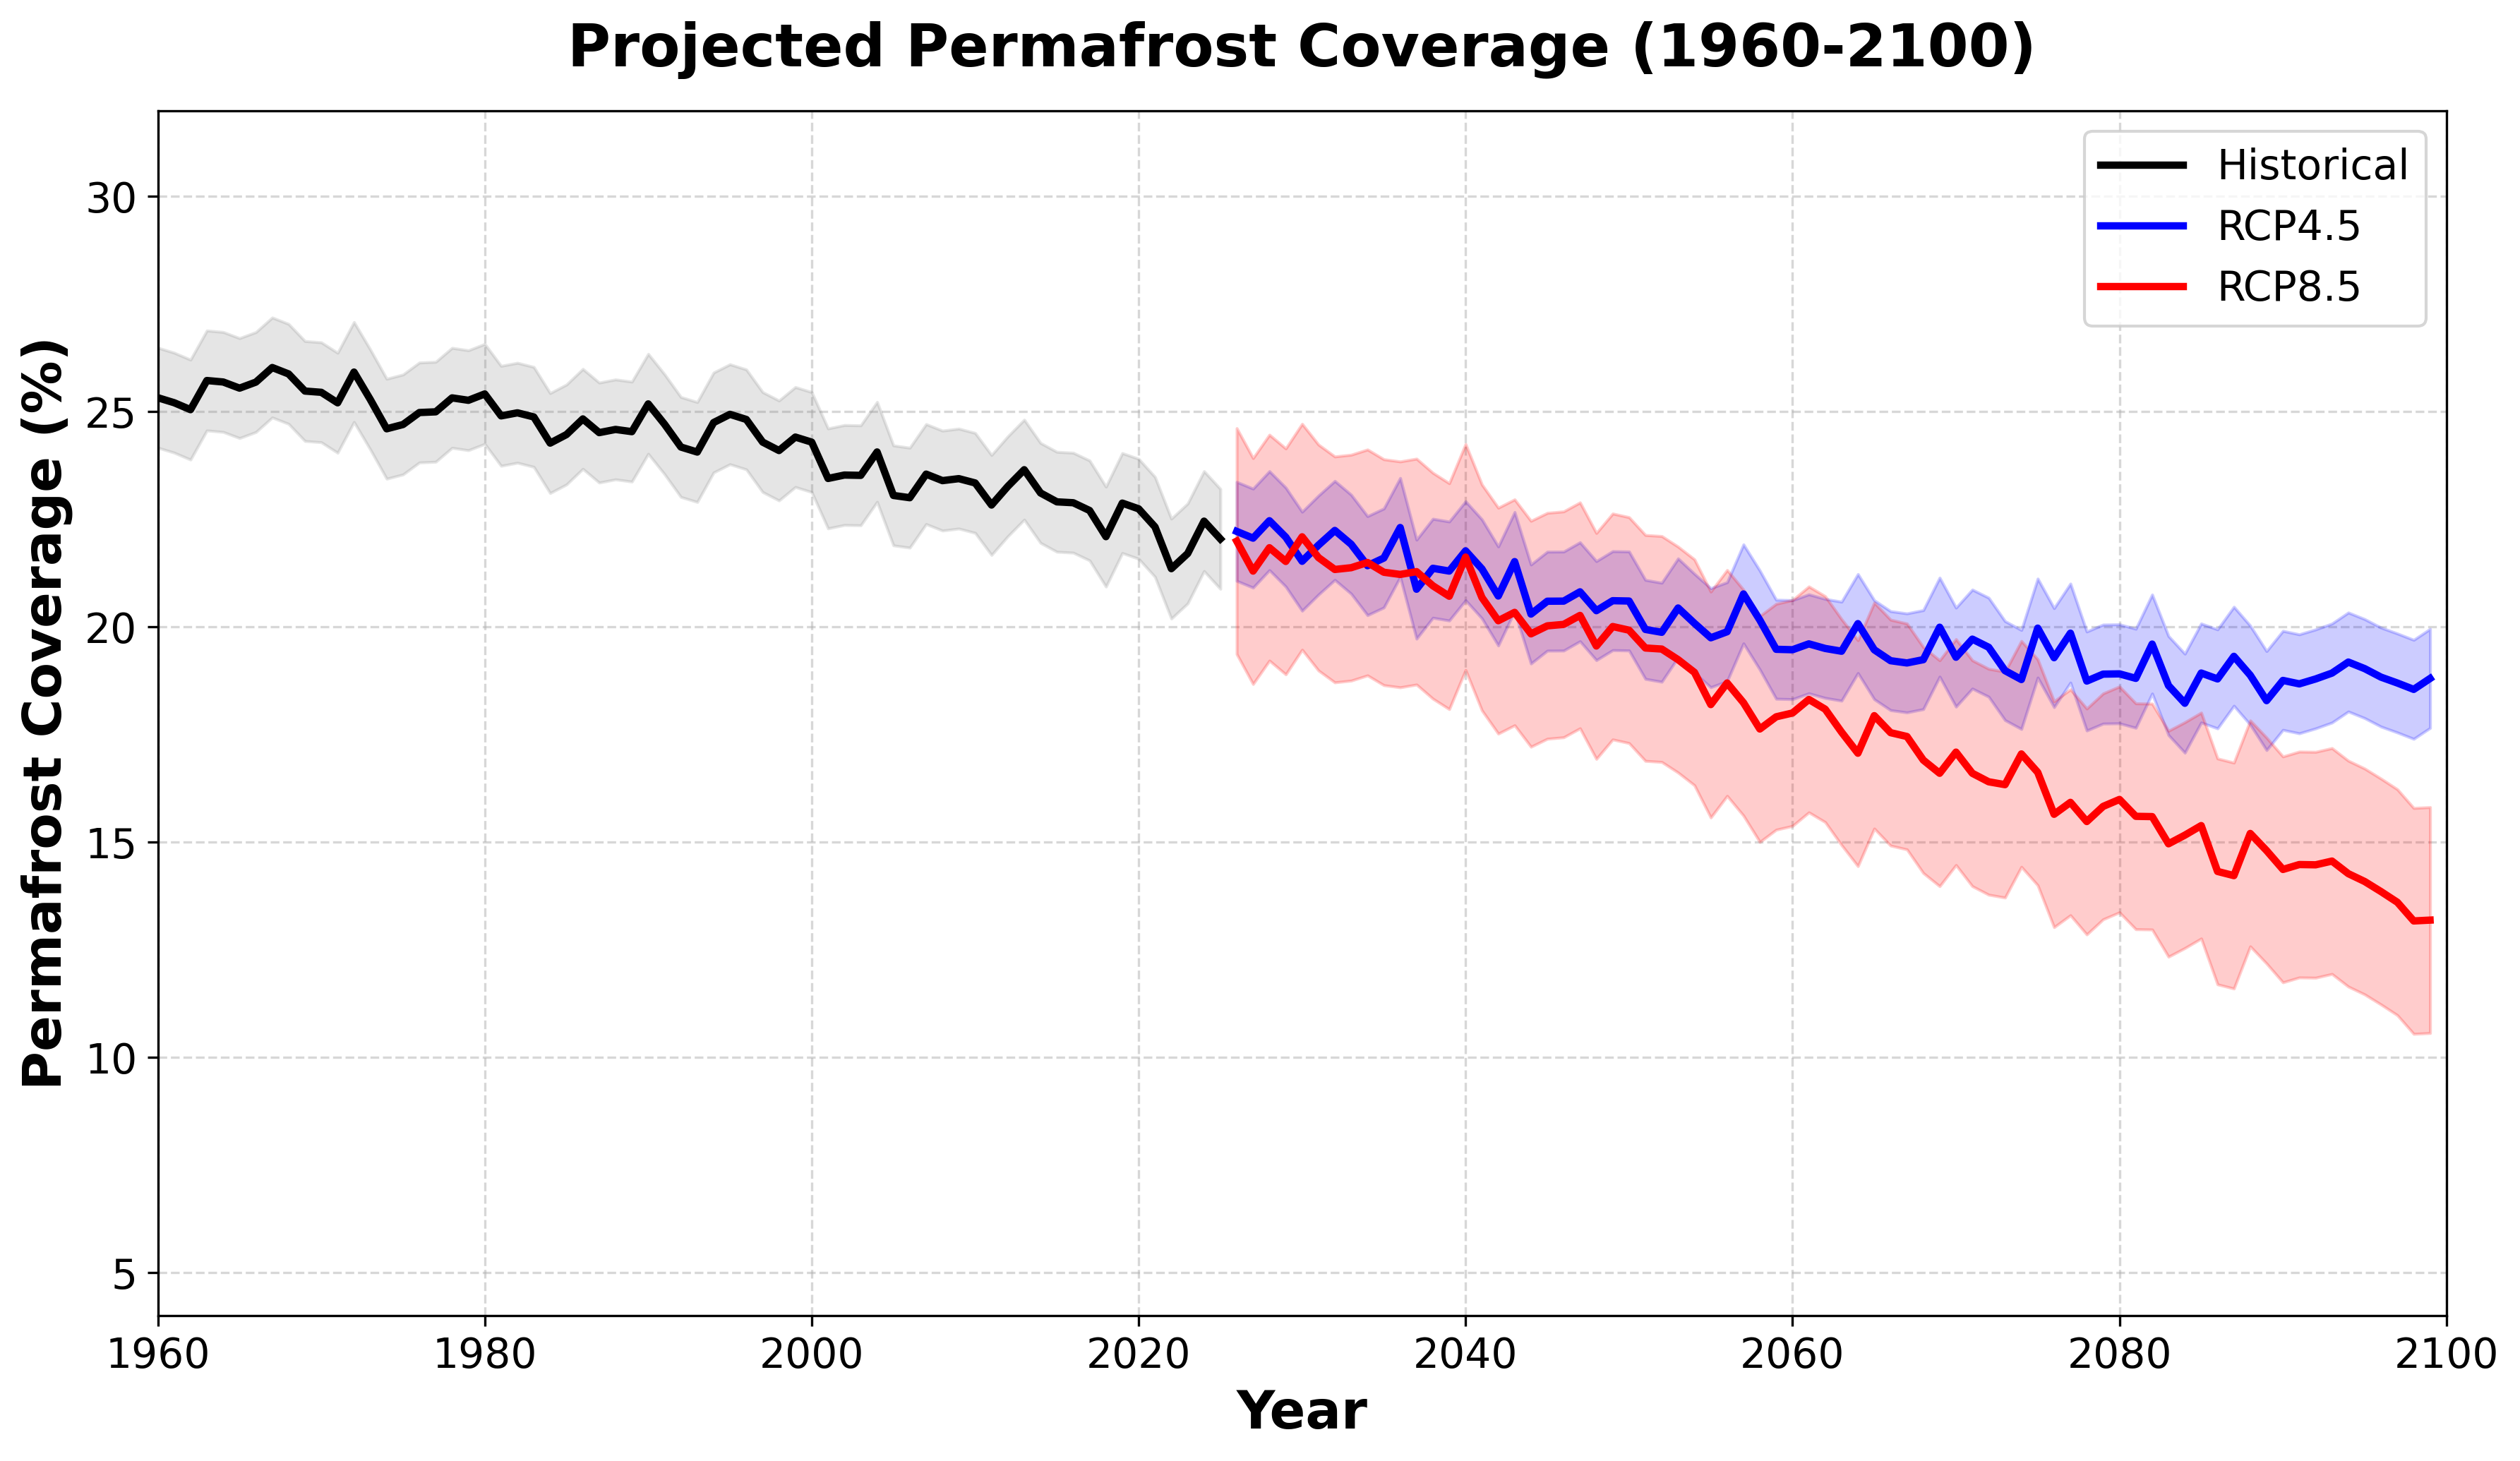

In [87]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Paths to data files
data_dir = "/glade/derecho/scratch/renatob/vic_alaska/output/"
file_hist = data_dir + "cmip5_ensemble_eb_rcp45.nc"
file_rcp45 = data_dir + "cmip5_ensemble_eb_rcp45.nc"
file_rcp85 = data_dir + "cmip5_ensemble_eb_rcp85.nc"

# Load datasets
ds_hist = xr.open_dataset(file_hist).sel(time=slice("1950-01-01", "2025-12-31"))
ds_rcp45 = xr.open_dataset(file_rcp45).sel(time=slice("2025-01-01", "2100-12-31"))
ds_rcp85 = xr.open_dataset(file_rcp85).sel(time=slice("2025-01-01", "2100-12-31"))

# Function to compute permafrost coverage over time (removing seasonality)
def permafrost_coverage(ds, temp_var, min_years=2):
    temp = ds[temp_var]
    frozen_years = temp <= 0  # Boolean mask where temp ≤ 0°C
    rolling_sum = frozen_years.rolling(time=min_years, center=False).sum()
    consecutive_frozen = rolling_sum >= min_years
    coverage = consecutive_frozen.mean(dim=["x", "y"]) * 100  # Convert to percentage
    
    # Convert from monthly to yearly averages
    coverage_yearly = coverage.groupby("time.year").mean()
    
    return coverage_yearly.compute()

# Compute permafrost coverage for historical and future scenarios
coverage_hist = permafrost_coverage(ds_hist, "SOIL_TEMP3")  # Deep layer
coverage_rcp45 = permafrost_coverage(ds_rcp45, "SOIL_TEMP3")
coverage_rcp85 = permafrost_coverage(ds_rcp85, "SOIL_TEMP3")

# Convert permafrost coverage to NumPy arrays
years_hist = coverage_hist.year.values
years_rcp = coverage_rcp45.year.values  # Both RCP datasets share the same years
coverage_hist = coverage_hist.values
coverage_rcp45 = coverage_rcp45.values
coverage_rcp85 = coverage_rcp85.values

# Compute uncertainty as ±1 standard deviation over time (Dynamic)
uncertainty_hist = np.std(coverage_hist)
uncertainty_rcp45 = np.std(coverage_rcp45)
uncertainty_rcp85 = np.std(coverage_rcp85)

# **Plot setup for publication**
fig, ax = plt.subplots(figsize=(12, 7), dpi=300)  # Increased figure size for clarity

# Historical coverage (1950-2025)
ax.plot(years_hist, coverage_hist, color="black", linewidth=2.5, label="Historical", zorder=3)
ax.fill_between(years_hist, 
                coverage_hist - uncertainty_hist, 
                coverage_hist + uncertainty_hist, 
                color="gray", alpha=0.2, zorder=2)

# RCP4.5 (2025-2100)
ax.plot(years_rcp[1:], coverage_rcp45[1:], color="blue", linewidth=2.5, label="RCP4.5", zorder=3)
ax.fill_between(years_rcp[1:], 
                coverage_rcp45[1:] - uncertainty_rcp45, 
                coverage_rcp45[1:] + uncertainty_rcp45, 
                color="blue", alpha=0.2, zorder=2)

# RCP8.5 (2025-2100)
ax.plot(years_rcp[1:], coverage_rcp85[1:], color="red", linewidth=2.5, label="RCP8.5", zorder=3)
ax.fill_between(years_rcp[1:], 
                coverage_rcp85[1:] - uncertainty_rcp85, 
                coverage_rcp85[1:] + uncertainty_rcp85, 
                color="red", alpha=0.2, zorder=2)

# **Labels, Legend, and Title**
ax.set_xlabel("Year", fontsize=18, fontweight="bold")
ax.set_ylabel("Permafrost Coverage (%)", fontsize=18, fontweight="bold")
ax.set_title("Projected Permafrost Coverage (1960-2100)", fontsize=20, fontweight="bold", pad=15)
ax.legend(fontsize=14, loc="upper right", frameon=True)

# **Grid and Formatting**
ax.grid(True, linestyle="--", alpha=0.5)
ax.set_xlim(1960, 2100)
ax.set_ylim(4, 32)  # Adjust permafrost coverage range
ax.tick_params(axis="both", which="major", labelsize=14)

# **Save and Show Plot**
plt.tight_layout()
plt.savefig("Fig3_A.pdf", dpi=300, bbox_inches="tight")
plt.show()
